In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level="INFO")

# Graphein - Atom Graph Tutorial

In this notebook, we'll run through residue-level graph construction in Graphein. We start by discsussing the config, the high-level API and spend the bulk of the tutorial running through the low-level API. First, let's take a look at our protein of interest: here's one I prepared earlier ;)

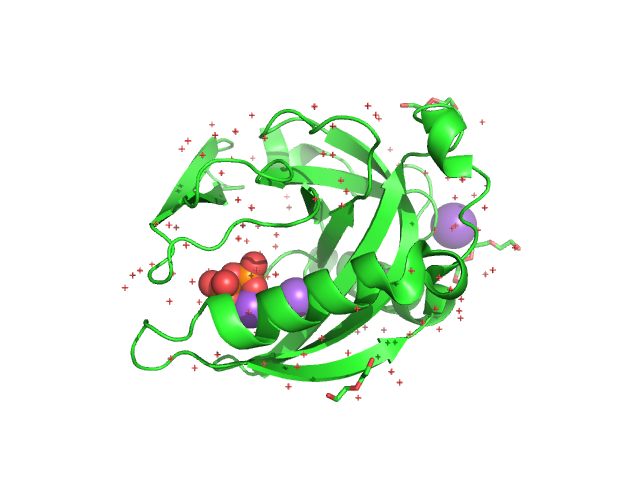

In [3]:
# NBVAL_SKIP
from graphein.utils.pymol import MolViewer
pymol = MolViewer()
pymol.fetch('3eiy')
pymol.display()

## Config

In [2]:
from graphein.protein.config import ProteinGraphConfig

config = ProteinGraphConfig()
config.dict()

INFO:summarizer.preprocessing.cleaner:'pattern' package not found; tag filters are not available for English


{'granularity': 'CA',
 'keep_hets': False,
 'insertions': False,
 'pdb_dir': PosixPath('../examples/pdbs'),
 'verbose': True,
 'exclude_waters': True,
 'deprotonate': False,
 'protein_df_processing_functions': None,
 'edge_construction_functions': [<function graphein.protein.edges.distance.add_peptide_bonds(G: 'nx.Graph') -> 'nx.Graph'>],
 'node_metadata_functions': [<function graphein.protein.features.nodes.amino_acid.meiler_embedding(n, d) -> pandas.core.series.Series>],
 'edge_metadata_functions': None,
 'graph_metadata_functions': None,
 'get_contacts_config': None,
 'dssp_config': None}

Let's run through the config:

* `granularity`: specifies the granularity of the graph (i.e. what should the nodes be). Possible values are: atom identifiers (e.g. `"CA"` for $\alpha$ carbon, `"CB"` for $\beta$ carbon), `"centroid"` to use residue centroids (under the hood, this is the same as "CA", but we use the average x,y,z coordinates for the atoms in the residue) or `"atom"` for atom-level construction. This is discussed here.
* `keep_hets`: this is a boolean specifying whether or not to keep heteroatoms present in the .pdb file. Heteroatoms are typically non-protein atoms (waters, metal ions, ligands) but can sometimes contain non-standard or modified residues.
* `insertions`: boolean specifying whether or not to keep insertions in the PDB file
* `pdb_dir` optional path to a folder in which to save pdb files. Otherwise, `/tmp/` will be used
* `verbose`: bool controlling amount of info printed
* `exclude_waters`: not implemented
* `deprotonate`: bool indicating whether or not to remove Hydrogen atoms
* `protein_df_processing_functions`: list of functions with which to process the PDB dataframe. Discussed in the low-level API.
* `edge_construction_functions`: list of functions to compute edges with
* `node_metadata_functions`: list of functions to annotate nodes with
* `edge_metadata_functions`: list of functions to annotate edges with
* `graph_meta_functions`: list of functions to annotate graph with
* `get_contacts_config`: A separate config object if using GetContacts edge construction functions

In [3]:
from graphein.protein.edges.atomic import add_atomic_edges
params_to_change = {"granularity": "atom", "edge_construction_functions": [add_atomic_edges]}

config = ProteinGraphConfig(**params_to_change)
config.dict()

{'granularity': 'atom',
 'keep_hets': False,
 'insertions': False,
 'pdb_dir': PosixPath('../examples/pdbs'),
 'verbose': True,
 'exclude_waters': True,
 'deprotonate': False,
 'protein_df_processing_functions': None,
 'edge_construction_functions': [<function graphein.protein.edges.atomic.add_atomic_edges(G: networkx.classes.graph.Graph) -> networkx.classes.graph.Graph>],
 'node_metadata_functions': [<function graphein.protein.features.nodes.amino_acid.meiler_embedding(n, d) -> pandas.core.series.Series>],
 'edge_metadata_functions': None,
 'graph_metadata_functions': None,
 'get_contacts_config': None,
 'dssp_config': None}

## High-level API
Graphein features a high-level API which should be applicable for most simple graph constructions. This can be used on either a .pdb file (so you can run whatever pre-processing you wish), or we can provide a PDB accession code and retrieve a structure from the PDB itself. If a path is provided, it takes precedence over the PDB code.

To use it we do as follows:

In [4]:
from graphein.protein.graphs import construct_graph

g = construct_graph(config=config, pdb_code="3eiy")
# To use a local file, you can do:
# g = construct_graph(config=config, pdb_path="../examples/pdbs/3eiy.pdb")

/home/atj39/github/graphein/graphein/protein/visualisation.py:330: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, auto_add_to_figure=True)


Text(0.5, 0.98, 'Atom-level graph. Nodes coloured by their Element')

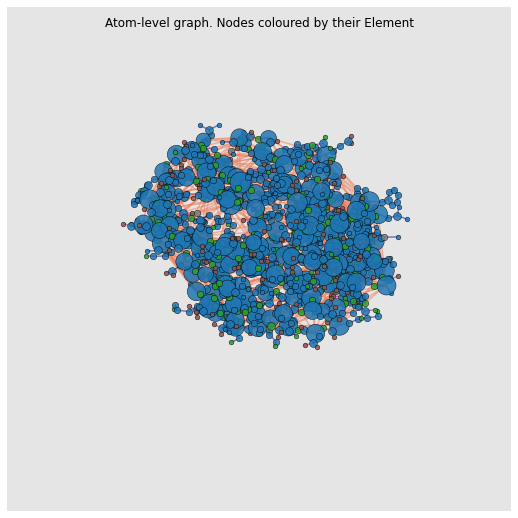

In [12]:
from graphein.protein.visualisation import plot_protein_structure_graph

p = plot_protein_structure_graph(G=g, angle=0, colour_edges_by="kind", colour_nodes_by="element_symbol", label_node_ids=False, node_size_min=2, node_alpha=0.85, node_colour_map=plt.cm.tab10)
plt.suptitle("Atom-level graph. Nodes coloured by their Element")

As you can see, all the bond types are the same. In order to add bond order assignment, we need to pass the `add_bond_order` function to the list of edge functions. We do the same for assigning ring status with `add_ring_status`

/home/atj39/github/graphein/graphein/protein/visualisation.py:330: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, auto_add_to_figure=True)


A:SER:2:N A:SER:2:CA {'kind': {'SINGLE', 'covalent'}, 'bond_length': 1.4964471256947236}
A:ASN:5:CG A:ASN:5:OD1 {'kind': {'DOUBLE', 'covalent'}, 'bond_length': 1.2476606109034614}
A:LYS:10:C A:ASP:11:N {'kind': {'DOUBLE', 'covalent'}, 'bond_length': 1.3200488627319846}
A:GLN:14:CA A:GLN:14:C {'kind': {'SINGLE', 'covalent'}, 'bond_length': 1.5587077981456363}
A:ASN:17:CA A:ASN:17:CB {'kind': {'SINGLE', 'covalent'}, 'bond_length': 1.5510625390357422}
A:GLU:21:CA A:GLU:21:C {'kind': {'SINGLE', 'covalent'}, 'bond_length': 1.541464563329304}
A:GLN:25:CA A:GLN:25:C {'kind': {'SINGLE', 'covalent'}, 'bond_length': 1.5395742918092665}
A:PRO:28:CG A:PRO:28:CD {'kind': {'SINGLE', 'covalent', 'RING'}, 'bond_length': 1.5008284378968835}
A:GLU:32:N A:GLU:32:CA {'kind': {'SINGLE', 'covalent'}, 'bond_length': 1.4628581612719675}
A:LYS:35:CE A:LYS:35:NZ {'kind': {'SINGLE', 'covalent'}, 'bond_length': 1.5094432748533508}
A:LEU:40:C A:VAL:41:N {'kind': {'DOUBLE', 'covalent'}, 'bond_length': 1.32749425610

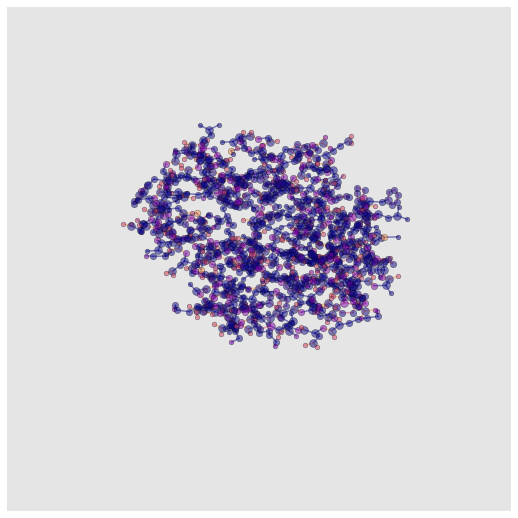

In [10]:
from graphein.protein.edges.atomic import add_atomic_edges, add_bond_order, add_ring_status
params_to_change = {"granularity": "atom", "edge_construction_functions": [add_atomic_edges, add_bond_order, add_ring_status]}

config = ProteinGraphConfig(**params_to_change)
g = construct_graph(config=config, pdb_code="3eiy")
p = plot_protein_structure_graph(G=g, angle=0, colour_edges_by="kind", colour_nodes_by="element_symbol", label_node_ids=False, node_size_min=2, node_alpha=0.5)

# Print some edges to verify
for i, (u, v, a) in enumerate(g.edges(data=True)):
    if i % 30 == 0:
        print(u, v, a)

We can also include some of the distance-based functions we used in the residue graph construction. Here we add the residue-level delaunay triangulation to the graph.

/home/atj39/github/graphein/graphein/protein/visualisation.py:330: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, auto_add_to_figure=True)


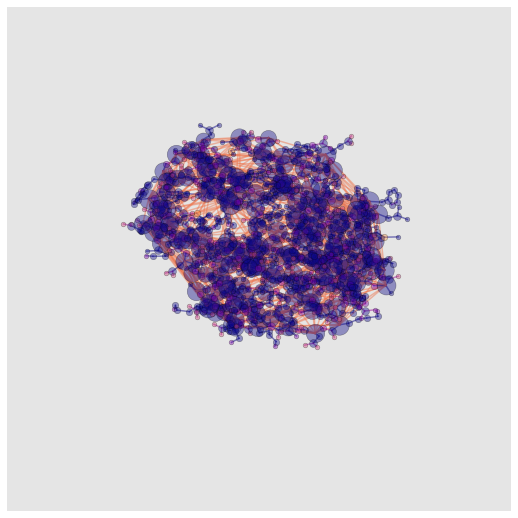

In [11]:
from graphein.protein.edges.distance import add_delaunay_triangulation
params_to_change = {"granularity": "atom", "edge_construction_functions": [add_atomic_edges, add_bond_order, add_delaunay_triangulation]}

config = ProteinGraphConfig(**params_to_change)
g = construct_graph(config=config, pdb_code="3eiy")
p = plot_protein_structure_graph(G=g, angle=0, colour_edges_by="kind", colour_nodes_by="element_symbol", label_node_ids=False, node_size_min=2, node_alpha=0.4)